# 1. Setup

Use GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). The Diffusion Transformer architecture implemented here runs with CUDA, therefore a Nvidia GPU is needed at the moment. I currently execute this for every run due to Colab restrictions. I first remove the old version of the repo and the clone the newer one. This is not required if running on a personal machine.

In [8]:
!rm -rf /content/Diffusion
%cd /content




/content


Clone the correct branch of the repo

In [9]:
!git clone -b fix-prediction-scales --single-branch https://github.com/Riccardo582/Diffusion.git
%cd Diffusion/


Cloning into 'Diffusion'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 474 (delta 49), reused 170 (delta 27), pack-reused 280 (from 1)
Receiving objects: 100% (474/474), 6.39 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (212/212), done.
/content/Diffusion


*Verify number of GPU available*

In [44]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())


CUDA available: True
GPU count: 1


# 2. Generating the datasets
At this stage I am using datasets from [neuraloperator](https://github.com/neuraloperator/neuraloperator) which is the same benchmark used in the FNO and SimDiffPDE papers. 
To get those I import the neuraloperator model and run the DarcyDataset() function, which downloads the data from [zenodo](https://zenodo.org). 
This function allows the user to select the size, resolution and batch size of both training set and test set.
There are multiple other datasets that can be downloaded use

In [ ]:
%pip -q install "git+https://github.com/neuraloperator/neuraloperator.git"

import neuralop, pkgutil

print("neuralop.__file__ =", neuralop.__file__)
print("neuralop.__path__ =", list(neuralop.__path__))

# list top-level subpackages under neuralop
tops = sorted([m.name for m in pkgutil.iter_modules(neuralop.__path__)])
print("top-level under neuralop:", tops)

# ensure the nested package exists
import neuralop.data
print("neuralop.data.__path__ =", list(neuralop.data.__path__))

subs = sorted([m.name for m in pkgutil.iter_modules(neuralop.data.__path__)])
print("subpackages under neuralop.data:", subs)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
neuralop.__file__ = /usr/local/lib/python3.12/dist-packages/neuralop/__init__.py
neuralop.__path__ = ['/usr/local/lib/python3.12/dist-packages/neuralop']
top-level under neuralop: ['data', 'layers', 'losses', 'models', 'mpu', 'tests', 'training', 'utils']
neuralop.data.__path__ = ['/usr/local/lib/python3.12/dist-packages/neuralop/data']
subpackages under neuralop.data: ['datasets', 'transforms']


In [ ]:
from pathlib import Path
from neuralop.data.datasets.darcy import DarcyDataset

root = Path("./data/neuralop_darcy").resolve()
ds = DarcyDataset(
    root_dir=root,
    n_train=100,
    n_tests=[16, 32],
    batch_size=8,
    test_batch_sizes=[16,16],
    train_resolution=32,
    test_resolutions=[16, 32],
    download=True,
)

#Debugging dataset location, had issues with conflicting neuralop paths
print("root:", root)
print("files:", sorted([p.name for p in root.iterdir()]))
print("exists darcy_test_32:", (root/"darcy_test_32.pt").exists())
print("exists darcy_train_32:", (root/"darcy_train_32.pt").exists())

Loading test db for resolution 16 with 16 samples 
Loading test db for resolution 32 with 32 samples 
root: /content/Diffusion/data/neuralop_darcy
files: ['._darcy_test_16.pt', '._darcy_train_16.pt', 'darcy_16.tgz', 'darcy_32.tgz', 'darcy_test_16.pt', 'darcy_test_32.pt', 'darcy_train_16.pt', 'darcy_train_32.pt']
exists darcy_test_32: True
exists darcy_train_32: True


# 3. Train the model
For this version, the model is built to train on square grids (images) and processes data stored as .pt.  
During training I first print the specifics of the Diffusion Transformer and then at every epoch some statistics on the error for both the low noise case (first timesteps) and the general case.    
The training script is defined in train.py.  
In this version the positional encoding is 2D sinusoidal, but in future versions it will switch to a token-based formulation.  
global-batch-size defines total number of samples processed in one optimization step across all GPUs combined.


In [12]:
!torchrun --nnodes=1 --nproc_per_node=1 train.py \
  --model DiT-S/2 \
  --data-path /content/Diffusion/data/neuralop_darcy/darcy_train_32.pt \
  --ckpt-every 400 \
  --image-size 32 \
  --cx 1 \
  --cy 1 \
  --epochs 25 \
  --global-batch-size 16 \
  --num-workers 1 \
  --pos-mode grid_sincos 


Starting rank=0, seed=0, world_size=1.
[2026-02-25 13:52:10] Experiment directory created at results/000-DiT-S-2
model_mean_type = ModelMeanType.EPSILON
model_var_type = ModelVarType.FIXED_LARGE
loss_type = LossType.MSE
[2026-02-25 13:52:11] DiT Parameters: 32,466,820
[2026-02-25 13:52:11] Dataset contains 5,000 PDE samples (/content/Diffusion/data/neuralop_darcy/darcy_train_32.pt)
[2026-02-25 13:52:11] Training for 25 epochs...
[2026-02-25 13:52:11] Beginning epoch 0...
x_cond shape: torch.Size([16, 1, 32, 32])
y shape: torch.Size([16, 1, 32, 32])
model type: <class 'torch.nn.parallel.distributed.DistributedDataParallel'>
inner type: <class 'models.DiT'>
inner forward: <bound method DiT.forward of DiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(2, 384, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=384, bias=True)
      (1): SiLU()
      (2): Linear(in_features=3

Plot error curve on a semilogy scale

checkpoints  log.txt
Parsed 78 points from results/000-DiT-S-2/log.txt


/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:85: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:89: PyparsingDeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2010: PyparsingDeprecationWarning: 'oneOf' deprecated - use 'one_of'
  p.space          = oneOf(self._space_widths)("space")
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2020: PyparsingDeprecationWarning: 'leaveWhitespace' deprecated - use 'leave_whitespace'
  )("sym").leaveWhitespace()
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:1984: PyparsingDeprecationWarning: 'setName' deprecated - use 'set_name'
  val.setName(key)
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:1987: PyparsingDeprecationWarning: 'setParseA

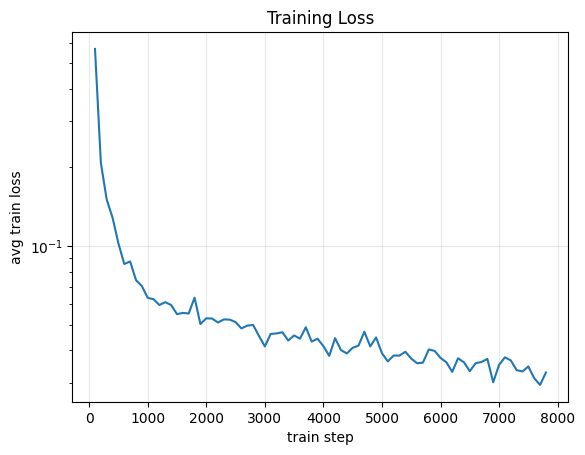

In [13]:

import re
import matplotlib.pyplot as plt

!ls results/000-DiT-S-2

LOG = "results/000-DiT-S-2/log.txt"  

steps, loss = [], []
pat = re.compile(r"\(step=(\d+)\)\s+Train Loss:\s+([0-9.]+)")

with open(LOG, "r") as f:
    for line in f:
        m = pat.search(line)
        if m:
            steps.append(int(m.group(1)))
            loss.append(float(m.group(2)))

print(f"Parsed {len(loss)} points from {LOG}")
if len(loss) == 0:
    raise SystemExit("No loss lines found. Check LOG path or log format")

plt.figure()
plt.semilogy(steps, loss)
plt.xlabel("train step")
plt.ylabel("avg train loss")
plt.title("Training Loss")
plt.grid(alpha=0.3)
plt.show()



# 4. Sample from the trained model
This sampling procedure defined in sample_ddp.py loads a trained DiT checkpoint and performs reverse diffusion to generate PDE solution fields.  
The model conditions on the input field, applies sinusoidal grid positional encoding, and iteratively denoises Gaussian noise over a number of sampling steps defined by the user.  
At every iteration I print some statistics on the true and sampled fields to have insights on the sampling process.

Verify checkpoint numbers files

In [ ]:
%ls results/000-DiT-S-2/checkpoints/

0000400.pt  0002000.pt  0003600.pt  0005200.pt  0006800.pt
0000800.pt  0002400.pt  0004000.pt  0005600.pt  0007200.pt
0001200.pt  0002800.pt  0004400.pt  0006000.pt  0007600.pt
0001600.pt  0003200.pt  0004800.pt  0006400.pt


**num-fid-samples** defines the total number of solution fields to generate during sampling (used for evaluation statistics).  
**num-sampling-steps** defines the number of denoising steps.  
**per-proc-batch-size** defines defines the number of samples generated simultaneously by each process during sampling.



In [ ]:
!torchrun --nproc_per_node=1 sample_ddp.py \
  --model DiT-S/2 \
  --dataset-pt data/datasets/data/darcy_test_32.pt \
  --ckpt results/000-DiT-S-2/checkpoints/0007600.pt \
  --H 32 --W 32 --cx 1 --cy 1 \
  --per-proc-batch-size 16 \
  --num-fid-samples 64 \
  --pos-mode grid_sincos \
  --sample-dir samples_pde \
  --num-sampling-steps 300 

Starting rank=0, seed=0, world_size=1.
CKPT: results/000-DiT-S-2/checkpoints/0007600.pt
ckpt args: DiT-S/2 32 1 1 grid_sincos phys_dim 0
loaded: ema
model_mean_type = ModelMeanType.EPSILON
model_var_type = ModelVarType.FIXED_LARGE
loss_type = LossType.MSE
/usr/local/lib/python3.12/dist-packages/torch/distributed/c10d_logger.py:83: UserWarning: barrier(): using the device under current context. You can specify `device_id` in `init_process_group` to mute this warning.
  return func(*args, **kwargs)
[rank0]:[W225 14:30:01.743871574 ProcessGroupNCCL.cpp:5138] Guessing device ID based on global rank. This can cause a hang if rank to GPU mapping is heterogeneous. You can specify device_id in init_process_group()
Total number of fields that will be sampled: 256
Sampling fields:   0% 0/16 [00:00<?, ?it/s]x_cond mean/std: 0.4986572265625 0.5000134706497192
y mean/std: 0.3874436616897583 0.3185466229915619
ONE-STEP cos: 0.96796715259552 rel: 0.7812582850456238 std_ratio: 1.655724048614502
SAMP m

Verify the structure of the sampled fields

In [19]:
import numpy as np

path = "samples_pde/samples_rank0000.npz"
d = np.load(path)

# list keys
print("keys:", d.files)

# shapes and data types
for k in d.files:
    v = d[k]
    print(f"{k:10s}  shape={v.shape}  dtype={v.dtype}")

for k in ("H","W","cx","cy","seed","model","ckpt"):
    if k in d.files:
        v = d[k]
        try:
            print(k, v.item())
        except Exception:
            print(k, v)



keys: ['x_cond', 'y_true', 'y_sample', 'H', 'W', 'cx', 'cy', 'model', 'ckpt', 'seed']
x_cond      shape=(256, 1, 32, 32)  dtype=float32
y_true      shape=(256, 1, 32, 32)  dtype=float32
y_sample    shape=(256, 1, 32, 32)  dtype=float32
H           shape=()  dtype=int64
W           shape=()  dtype=int64
cx          shape=()  dtype=int64
cy          shape=()  dtype=int64
model       shape=()  dtype=<U7
ckpt        shape=()  dtype=<U42
seed        shape=()  dtype=int64
H 32
W 32
cx 1
cy 1
seed 0
model DiT-S/2
ckpt results/000-DiT-S-2/checkpoints/0007600.pt


Plot the sampled field and confront it with the true one and the conditioning.
To have a better visualization of the error I also plot directly the error. I noticed that the colors of the error plot can be misleading when evaluating the actual precision of the model.

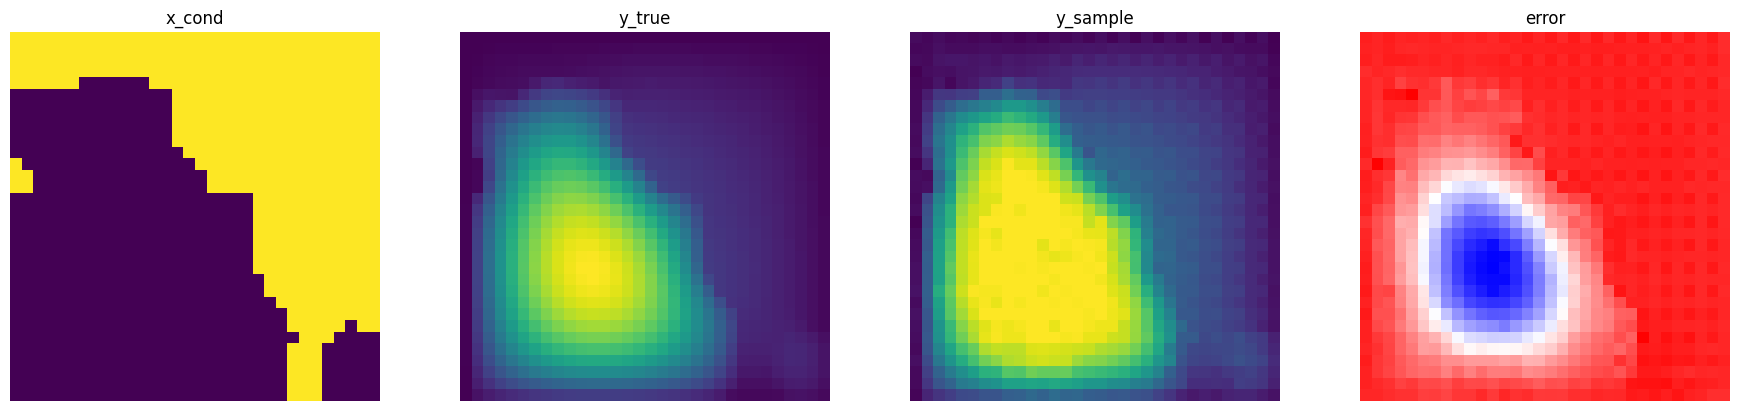

In [20]:

d = np.load(path)
x = d["x_cond"]      # (N,Cx,H,W)
yt = d.get("y_true") # (N,Cy,H,W) or missing
ys = d["y_sample"]   # (N,Cy,H,W)

i = 0
cx = 0
cy = 0

fig, ax = plt.subplots(1, 4 if yt is not None else 2, figsize=(18,4), constrained_layout=True)

ax[0].imshow(x[i, cx]); ax[0].set_title("x_cond"); ax[0].axis("off")
if yt is not None:
    ax[1].imshow(yt[i, cy]); ax[1].set_title("y_true"); ax[1].axis("off")
    ax[2].imshow(ys[i, cy]); ax[2].set_title("y_sample"); ax[2].axis("off")
    ax[3].imshow(ys[i, cy] - yt[i, cy], cmap="bwr"); ax[3].set_title("error"); ax[3].axis("off")
else:
    ax[1].imshow(ys[i, cy]); ax[1].set_title("y_sample"); ax[1].axis("off")

plt.show()


Evaluate the prediction error by evaluating different statistics

In [ ]:
import numpy as np

yt = d["y_true"]
ys = d["y_sample"]
err = ys-yt
mse = ((ys - yt)**2).mean()
rel = np.sqrt(((err)**2).mean()) / (np.sqrt((yt**2).mean()) + 1e-12)
print("MSE:", mse, "relative RMSE:", rel)
print("y_true mean/std:", yt.mean(), yt.std())
print("y_samp mean/std:", ys.mean(), ys.std())
print("error mean/std:", np.abs((err)).mean(), np.abs((err)).std())
print("absolute error mean/std:", np.abs((err)).mean(), np.abs((err)).std())
print("error min/max:", (err).min(), (err).max())
print("error percentiles:",np.percentile(err, [0.1, 1, 99, 99.9]))


MSE: 0.008783526 relative RMSE: 0.17782237
y_true mean/std: 0.40072787 0.3423361
y_samp mean/std: 0.37126434 0.28871915
error mean/std: -0.029463535 0.08896867
error min/max: -0.93550545 0.37451193
